# makemore_Bigrams
----
* Inspired by Andrej Karpathy's ["The spelled-out intro to language modeling: building makemore"](https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3)

* Useful links for practice
    - [Python + Numpy tutorial from CS231n](https://cs231n.github.io/python-numpy-tutorial/): We use `torch.tensor` instead of `numpy.array` in this video. Their design (e.g. broadcasting, data types, etc.) is so similar that practicing one is basically practicing the other, just be careful with some of the API.
    - [PyTorch tutorial on tensor](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html).
    - [Another PyTorch Intro. to Tensor](https://pytorch.org/tutorials/beginner/nlp/pytorch_tutorial.html).


# Table of Contents
------------------
- [0. Makemore: Introduction](#0)
    - [0.1. `PyTorch` Broadcasting Rules](#001)
- [1. Read & Explore Dataset](#1)
- [2. Bigrams: Frequency Counting Approach](#2)
    - [2.1. Counting Bigrams in a Python Dictionary](#201)
    - [2.2. Counting Bigrams in a `2D torch tensor` (Model Training)](#202)
    - [2.3. Visualizing the Bigram Tensor](#203)
    - [2.4. Replace Spurious Tokens (`<S>`, `<E>`) with Single Token (`.`)](#204)
    - [2.5. Sampling from Model](#205)
    - [2.6. Efficiency: Vectorized Normalization of the Rows & Tensor Broadcasting](#206)
    - [2.7. Model Quality: Loss Function](#207)
    - [2.8. Model Smoothing: Using Fake Counts](#208)
- [3. Bigrams: Gradient-Based Approach](#3)
    - [3.1. Bigram Dataset for Neural Network](#301)
    - [3.2. One-Hot Encoding](#302)
    - [3.3. The "Neural Net": One Linear Layer of Neurons Implemented with Matrix Multiplication](#303)
    - [3.4. Softmax: Transform NN Outputs to Probabilities](#304)
    - [3.5. Summary: Preview to Next Steps (Reference to Micrograd)](#305)
    - [3.6. Vectorized Loss](#306)
    - [3.7. `PyTorch`: Backward Pass & Parameter Update](#307)
    - [3.8. Putting Everything Together](#308)
    - [3.9. Notes: Breakdown of One-Hot Encoding](#309)
    - [3.10. Notes: Model Smoothing/Regularization Loss](#310)
    - [3.11. Sampling from Neural Net](#311)
- [4. Conclusion](#4)
------



# Appendix
---------------
## Figures
- [A1: Graph of Log(x) from x=0 to x=1.](#a1)
- [A2. Standard Normal Distribution.](#a2)
- [A3. Graph of Exp(x) from x=-1 to x=1.](#a3)

## Equations
- [C1: Negative Log Predictive Density (NLPD) or Negative Log-Likelihood (NLL).](#c1)
- [C2. Softmax Activation Function.](#c2)

## Definitions
- [D1. Makemore](#d1)
- [D2. Autoregressive model](#d2)
- [D3. PyTorch Broadcasting Rules](#d3)
- [D4. Statistical Model: Counts Frequency Distribution](#d4)
- [D5. Maximum Likelihood Estimation, MLE](#d5)
- [D6. Likelihood Function](#d6)
- [D7. Model Regularization: Model Smoothing](#d7)

## [Exercises](#e1)

## [References](#r1)

-----------
<br><br>
# 0. Makemore: Introduction<a id="0"></a>
---------------------------------
<a id="d1"></a><u>**Makemore**</u> takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an **autoregressive character-level language model**, with a <u>wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT)</u>. <a id="d2"></a>An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble. 

*"As the name suggests, makemore makes more."*

This is not meant to be too heavyweight of a library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. [PyTorch](https://pytorch.org) is the only requirement.

Current implementation follows a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

First, we implement a bigram character-level language model, which we will further complexify in followup videos into a modern Transformer language model, like GPT. In this lecture, the focus is on: 
1. introducing `torch.Tensor` and its subtleties and use in efficiently evaluating neural networks
2. the overall framework of language modeling that includes model training, sampling, and the evaluation of a loss (e.g. the negative log likelihood for classification).

------
## 0.1.  `PyTorch` Broadcasting Rules<a id="001"></a>
-----
<a id="d3"></a>
### Broadcasting: General Semantics
Let's go over PyTorch [broadcasting rules.](https://pytorch.org/docs/stable/notes/broadcasting.html) Two tensors are “broadcastable” if the following rules hold:

* Each tensor has at least one dimension.

* When iterating over the dimension sizes, starting at the trailing dimension from the right, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
x=torch.empty(5,7,3)
y=torch.empty(5,7,3)
# same shapes are always broadcastable (i.e. the above rules always hold)
(x+y).size()

torch.Size([5, 7, 3])

In [3]:
x=torch.empty((0,))
y=torch.empty(2,2)
# x and y are not broadcastable, because x does not have at least 1 dimension
#(x+y).size()

In [4]:
# can line up trailing dimensions
x=torch.empty(5,3,4,1)
y=torch.empty(  3,1,1)
# x and y are broadcastable.
# 1st trailing dimension: both have size 1
# 2nd trailing dimension: y has size 1
# 3rd trailing dimension: x size == y size
# 4th trailing dimension: y dimension doesn't exist
(x+y).size()

torch.Size([5, 3, 4, 1])

In [5]:
# but:
x=torch.empty(5,2,4,1)
y=torch.empty(  3,1,1)
# x and y are not broadcastable, because in the 3rd trailing dimension 2 != 3
#(x+y).size()

If two tensors `x`, `y` are “broadcastable”, the resulting tensor size is calculated as follows:

* If the number of dimensions of `x` and `y` are not equal, prepend 1 to the dimensions of the tensor with fewer dimensions to make them equal length.

* Then, for each dimension size, the resulting dimension size is the max of the sizes of `x` and `y` along that dimension.

For Example:

In [6]:
# can line up trailing dimensions to make reading easier
x=torch.empty(5,1,4,1)
y=torch.empty(  3,1,1)
(x+y).size()

torch.Size([5, 3, 4, 1])

In [7]:
# but not necessary to line up trailing dimensions:
x=torch.empty(1)
y=torch.empty(3,1,7)
(x+y).size()

torch.Size([3, 1, 7])

In [8]:
x=torch.empty(5,2,4,1)
y=torch.empty(3,1,1)
# x and y are not broadcastable, because in the 3rd trailing dimension 2 != 3
# (x+y).size()

### Broadcasting: In-place Semantics

One complication is that in-place operations do not allow the in-place tensor to change shape as a result of the broadcast.

For Example:

In [9]:
x=torch.empty(5,3,4,1)
y=torch.empty(3,1,1)
(x.add_(y)).size()

torch.Size([5, 3, 4, 1])

In [10]:
x=torch.empty(1,3,1)
y=torch.empty(3,1,7)
# x and y are not broadcastable, because 
# output with shape [1, 3, 1] doesn't match the broadcast shape [3, 3, 7]
#(x.add_(y)).size()

### Broadcasting: Backwards Compatibility
Prior versions of PyTorch allowed certain pointwise functions to execute on tensors with different shapes, as long as the number of elements in each tensor was equal. The pointwise operation would then be carried out by viewing each tensor as 1-dimensional. PyTorch now supports broadcasting and the “1-dimensional” pointwise behavior is considered deprecated and will generate a Python warning in cases where tensors are not broadcastable, but have the same number of elements.

Note that the introduction of broadcasting can cause backwards incompatible changes in the case where two tensors do not have the same shape, but are broadcastable and have the same number of elements. For Example:



In [11]:
torch.add(torch.ones(4,1), torch.randn(4))

tensor([[-0.2513,  1.3080, -0.5782,  2.2858],
        [-0.2513,  1.3080, -0.5782,  2.2858],
        [-0.2513,  1.3080, -0.5782,  2.2858],
        [-0.2513,  1.3080, -0.5782,  2.2858]])

would previously produce a Tensor with size: `torch.Size([4,1])`, but now produces a Tensor with size: `torch.Size([4,4])`. In order to help identify cases in your code where backwards incompatibilities introduced by broadcasting may exist, you may set `torch.utils.backcompat.broadcast_warning.enabled` to `True`, which will generate a python warning in such cases.

For Example:

In [12]:
torch.utils.backcompat.broadcast_warning.enabled=True
torch.add(torch.ones(4,1), torch.ones(4))

tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])

---------
<br><br>
# 1. Read & Explore Dataset<a id="1"></a>
-------------------------------------------------------

### Usage

The included `names.txt` dataset, as an example, has the most common 32K names takes from [ssa.gov](https://www.ssa.gov/oact/babynames/) for the year 2018. It looks like:

```
emma
olivia
ava
isabella
sophia
charlotte
...
```


In [13]:
words = open('../data/names.txt', 'r').read().splitlines()

In [14]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [15]:
len(words)

32033

In [16]:
min(len(w) for w in words)

2

In [17]:
max(len(w) for w in words)

15

-------------
<br><br>
# 2. Bigrams: Frequency Counting Approach<a id="2"></a>
-------------------------------------------------------

We're always working with just 2 characters at a time. We're only looking at one character and trying to predict the next character in the sequence of that local structure. Basically, we're only looking at the previous character to predict the next one.

We start with a bigram model that works with only two characters at a time. We look at one character in the sequence and we try to predict the next one. We focus on local information and forget about global one (i.e. about full word).

Eventually in order to generate start and complete the name, we add an additional symbol `.` at the beginning and end of the name respectively. Thus, at the end of building our model, the first bigram of the name `Isabella` starts with `.i` and ends with `a.`.
Our dataset consists of bigrams. For each name we have multiple bigrams contributing to the dataset. For example, `Isabella` is split into `.i`, `is`, `sa`, …

But first, we use special **start** and **end** tokens.



<a id='d4'></a>
## Statistical Model: Counts Frequency Distribution
----
We start with a simple <u>statistical model</u> counting the frequency of bigram (pairs of letters) occurrence in our dataset. One can generate a frequency matrix `N` that shows how many bigrams ending with character `B` are in the dataset if it starts with character `A`. The count goes over all possible characters `A` and `B`, forming a 27x27 matrix eventually. Then transforms it to the probability matrix `P` by normalizing each cell by sum of row elements. This gives us the statistics of the bigrams. The elements of the probability matrix `P` are the parameters of our model which help us to generate bigrams.

Now one can use a <u>multinomial distribution</u> sampling to generate bigrams using the probability matrix `P`. We then merge these bigrams into names, using the start and end symbols `.` as separators.



------
## 2.1. Counting Bigrams in a Python Dictionary<a id="201"></a>
-----

Let’s take all two-character combinations of all the names.

To denote the start and the end of the sequence/name, we will use special start (`<S>`) and end (`<E>`) tokens. We get the bigrams of start and end characters.

In [18]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>'] # special start + word + special end
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        
        # add up all bigrams & count how often they occur
        b[bigram] = b.get(bigram, 0) + 1 # if bigram is not in the dictionary, b.get(bigram,0) returns 0

In [19]:
b.items()

dict_items([(('<S>', 'e'), 1531), (('e', 'm'), 769), (('m', 'm'), 168), (('m', 'a'), 2590), (('a', '<E>'), 6640), (('<S>', 'o'), 394), (('o', 'l'), 619), (('l', 'i'), 2480), (('i', 'v'), 269), (('v', 'i'), 911), (('i', 'a'), 2445), (('<S>', 'a'), 4410), (('a', 'v'), 834), (('v', 'a'), 642), (('<S>', 'i'), 591), (('i', 's'), 1316), (('s', 'a'), 1201), (('a', 'b'), 541), (('b', 'e'), 655), (('e', 'l'), 3248), (('l', 'l'), 1345), (('l', 'a'), 2623), (('<S>', 's'), 2055), (('s', 'o'), 531), (('o', 'p'), 95), (('p', 'h'), 204), (('h', 'i'), 729), (('<S>', 'c'), 1542), (('c', 'h'), 664), (('h', 'a'), 2244), (('a', 'r'), 3264), (('r', 'l'), 413), (('l', 'o'), 692), (('o', 't'), 118), (('t', 't'), 374), (('t', 'e'), 716), (('e', '<E>'), 3983), (('<S>', 'm'), 2538), (('m', 'i'), 1256), (('a', 'm'), 1634), (('m', 'e'), 818), (('<S>', 'h'), 874), (('r', 'p'), 14), (('p', 'e'), 197), (('e', 'r'), 1958), (('r', '<E>'), 1377), (('e', 'v'), 463), (('v', 'e'), 568), (('l', 'y'), 1588), (('y', 'n'), 18

In [20]:
# get 5 most common bigrams
sorted(b.items(), key = lambda kv: -kv[1])[:5]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983)]

In [21]:
# get 5 least common bigrams
sorted(b.items(), key = lambda kv: kv[1])[:5]

[(('q', 'r'), 1),
 (('d', 'z'), 1),
 (('p', 'j'), 1),
 (('q', 'l'), 1),
 (('p', 'f'), 1)]

------
## 2.2.  Counting Bigrams in a `2D torch tensor` (Model Training)<a id="202"></a>
-----
Storing this information in a 2D array is convenient. Rows are going to be the first character. Columns are going to be the second character. We use PyTorch to build this array representation.

PyTorch allows us to create and manipulate high-dimensional arrays efficiently. Initially to start, we want a 28 by 28 `N` matrix array because of the 26 letters of the alphabet, `<S>` character (start token), and `<E>` character (end token).


In [22]:
a = torch.zeros((3, 5))
a, a.dtype

(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]),
 torch.float32)

In [23]:
a = torch.zeros((3, 5), dtype=torch.int32)
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [24]:
a[1, 3] += 1
a

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

In [25]:
a[0,0] = 5
a

tensor([[5, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)

We have 26 letters of the alphabet and 2 special characters. So we want 28 characters. 


In [26]:
#define a 28 x 28 zero matrix
N = torch.zeros((28,28), dtype = torch.int32)

<u>Problem:</u> We have string characters that we have to now basically condense into an array using integers. We need a lookup table from characters to integers.

So let's construct a string character to integer mapping:

In [27]:
# A mapping from the strings to number
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['<S>']=26
stoi['<E>']=27

# count the bigrams
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs,chs[1:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            N[ix1, ix2] +=1

In [28]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<S>': 26,
 '<E>': 27}

In [29]:
print(f'The 1st 5 key-value pairs in the string to integer dict are: {list(stoi.items())[:5]}') 
print(f'The last 5 key-value pairs in the string to integer dict are: {list(stoi.items())[-5:]}') 

The 1st 5 key-value pairs in the string to integer dict are: [('a', 0), ('b', 1), ('c', 2), ('d', 3), ('e', 4)]
The last 5 key-value pairs in the string to integer dict are: [('x', 23), ('y', 24), ('z', 25), ('<S>', 26), ('<E>', 27)]


------
## 2.3. Visualizing the Bigram Tensor<a id="203"></a>
-----
Let’s try to visualize the matrix. We use the `matplotlib` library.

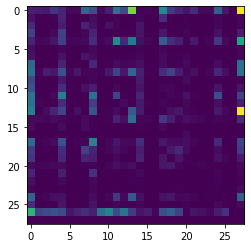

In [30]:
plt.imshow(N)

The plot above doesn't give any worthwhile information. We need a better heatmap. 

In [31]:
N[3,3].item()

149

However upon careful scrutiny of the visual representation of `N` matrix (28 x 28) with 28 characters, the end character (`<E>`) is never possibly going to be the 1st character of the bigram because we're always placing these end tokens at the end of the bigram. Similarly the start character (`<S>`) will never possibly be the 2nd element of a bigram because we always start with `<S>` and end with `<E>` and we only have the words in between. Basically, a character cannot come after the `<E>` token and a character cannot come before the `<S>` token.

Instead now we're going to replace both spurious tokens (`<S>`, `<E>`) with one special token `.` which has position `0`, and thereby we offset the position of the other letters. Now we only need 27 characters.

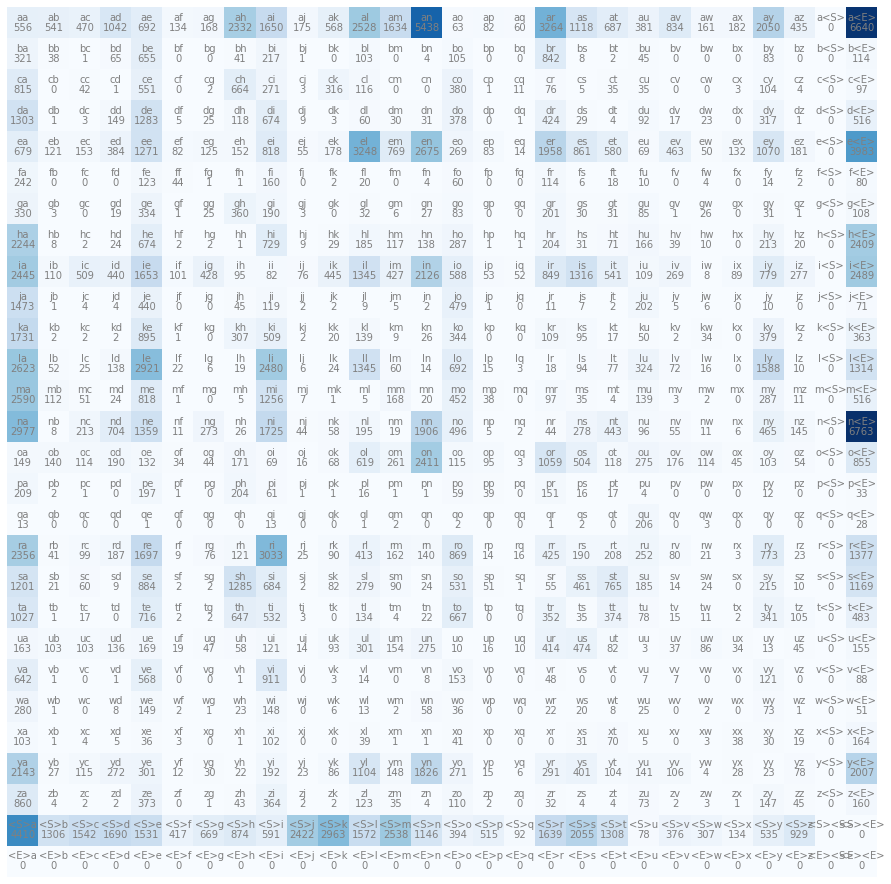

In [32]:
itos = {i:s for s,i in stoi.items()} # reverse of stoi dict (int_to_str)

plt.figure(figsize=(16,16))
#show the image of the matrix
plt.imshow(N,cmap = 'Blues')

for i in range(28):
    for j in range(28):
        #create a character string
        chstr = itos[i] + itos[j]

        plt.text(j,i, chstr, ha ="center", va = "bottom", color ="gray")
        plt.text(j,i, N[i,j].item(), ha ="center", va = "top", color ="gray")
        #When indexing to a pytorch tensor, gives a tensor. To get the value use N[.].item()

plt.axis('off');

------
## 2.4.  Replace Spurious Tokens (`<S>`, `<E>`) with Single Token (`.`)<a id="204"></a>
-----

However upon careful scrutiny of the visual representation of `N` matrix (28 x 28) with 28 characters, the end character (`<E>`) is never possibly going to be the 1st character of the bigram because we're always placing these end tokens at the end of the bigram. Similarly the start character (`<S>`) will never possibly be the 2nd element of a bigram because we always start with `<S>` and end with `<E>` and we only have the words in between. Basically, a character cannot come after the `<E>` token and a character cannot come before the `<S>` token.

To fix this, we're going to replace both spurious tokens (`<S>`, `<E>`) with one special token `.` which has position `0`, and thereby we have to offset the position of the other letters. Now we only need 27 characters.

In [33]:
N = torch.zeros((27, 27), dtype=torch.int32) #define a 28 x 28 zero matrix

In [34]:
chars = sorted(list(set(''.join(words)))) # character array 
stoi = {s:i+1 for i,s in enumerate(chars)} # string to integer mapping dict
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # reverse mapping of stoi dict (integer to string dict)

In [35]:
print(f'The 1st 5 key-value pairs in the string to integer dict are: {list(stoi.items())[:5]}') 
print(f'The 1st 5 key-value pairs in the reverse dict (int_to_str) are: {list(itos.items())[:5]}') 

The 1st 5 key-value pairs in the string to integer dict are: [('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5)]
The 1st 5 key-value pairs in the reverse dict (int_to_str) are: [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd'), (5, 'e')]


In [36]:
print(f'The last 5 key-value pairs in the string to integer dict are: {list(stoi.items())[-5:]}') 
print(f'The last 5 key-value pairs in the reverse dict (int_to_str) are: {list(itos.items())[-5:]}') 

The last 5 key-value pairs in the string to integer dict are: [('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)]
The last 5 key-value pairs in the reverse dict (int_to_str) are: [(23, 'w'), (24, 'x'), (25, 'y'), (26, 'z'), (0, '.')]


In [37]:
for w in words:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1   

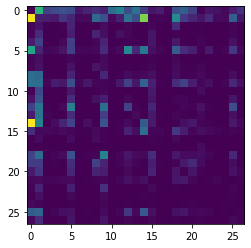

In [38]:
plt.imshow(N)

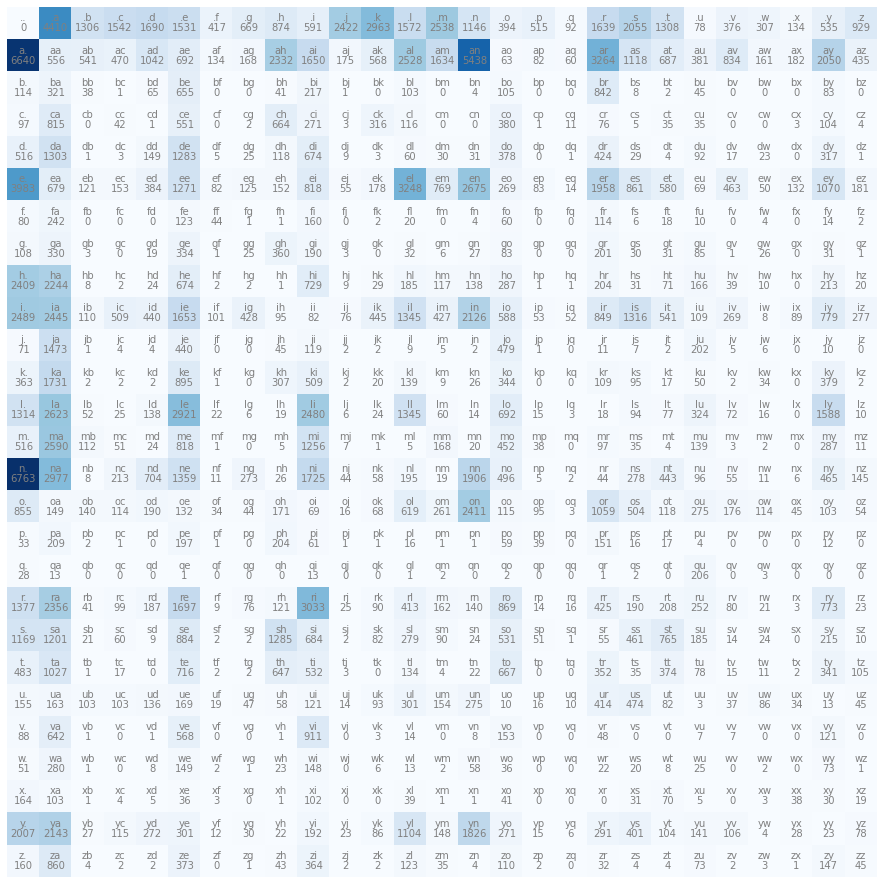

In [39]:
itos = {i:s for s,i in stoi.items()}

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

The first row shows the count for all the first letters. The first column shows the count for all the ending characters. This heatmap shows the counts array of our entire dataset. This count array has all the information necessary for us to actually sample from this bigram character-level language model.

------
## 2.5.  Sampling from Model<a id="205"></a>
-----
Now we need to sample from our bigram array. One can use a [multinomial distribution](https://pytorch.org/docs/stable/generated/torch.multinomial.html) sampling method from PyTorch to generate bigrams using the probability matrix `P`. The first row indicates the counts of the first letter occurring. We can turn it into probabilities in the following way.


In [40]:
N[0], N[0].shape    # N[0, :] = N[0]

(tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929], dtype=torch.int32),
 torch.Size([27]))

In [41]:
p = N[0].float() # float format needed for normalization
p = p / p.sum()  # create probability distribution
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

We use `torch.multinomial` to sample from this distribution. It returns samples from the multinomial probaility distribution. This means:

*"You give me probabilities and I will give you integers which are sampled according to the probability distribution."*

`torch.Generator` object makes things deterministic (keeps results fixed everytime you re-run calculations). First, let’s sample the first character.

In [42]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
ix, itos[ix]

(13, 'm')

In [43]:
g = torch.Generator().manual_seed(2147483647)
pp = torch.rand(3, generator=g)
pp = pp / pp.sum()
pp

tensor([0.6064, 0.3033, 0.0903])

In [44]:
torch.multinomial(pp, num_samples=10, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0])

In [45]:
pp.shape

torch.Size([3])

In [46]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0 # start from the start token character
    while True:
        p = N[ix].float()
        p = p / p.sum()
        #p = torch.ones(27)/ 27.0
        ix = torch.multinomial(p,num_samples=1, replacement = True, generator = g).item()
        #print(itos[ix], end ='')
        out.append(itos[ix])
        if ix == 0: # If it is the end token character break the loop
            break
    print("".join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


In [47]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [48]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


Bigram model is not a very good way to generate names. It only looks at the previous character. We should do better. 

------
## 2.6.  Efficiency: Vectorized Normalization of the Rows & Tensor Broadcasting<a id="206"></a>
-----
<a id="d1"></a>

### Vectorized Normalization of the Rows
Now after going through PyTorch broadcasting rules in [Section 0.1](#001), we need to sample from our bigram array. The first row indicates the counts of the first letter occurring. We can turn it into probabilities in the following way.

We're always fetching a row of `N` from the counts matrix, then we're converting to float and dividing, we're doing this every single iteration of this loop and we just keep renormalizing this rows over and over again. This is extremely inefficient and wasteful. To improve the efficiency, let's prepare `P` matrix that will have probailities only - same as `N` matrix of counts but instead of counts we will have normalized probabilities. Let’s change the `N` matrix to denote probabilities instead of counts.

This also helps us to understand n-dim tensors, their manipulation and [broadcasting rules.](https://pytorch.org/docs/stable/notes/broadcasting.html)

In [49]:
P = N.float()

In [50]:
P.shape

torch.Size([27, 27])

In [51]:
# Broadcasting rules check
# 27, 27  ---->  # 27, 27
#     27  ---->  #  1, 27 (row vector) the 1 that is added causes the bug

In [52]:
P.sum(1).shape

torch.Size([27])

In [53]:
P = N.float()
P = P / P.sum(1)
P[0].sum() , P.shape # P[0] --> 1st row of P

(tensor(7.0225), torch.Size([27, 27]))

In [54]:
[P[i].sum() for i in range(P.sum(1).shape[0])]

[tensor(7.0225),
 tensor(4.4142),
 tensor(0.2009),
 tensor(0.3717),
 tensor(0.4146),
 tensor(2.2968),
 tensor(0.1063),
 tensor(0.2065),
 tensor(0.4567),
 tensor(2.3526),
 tensor(0.2220),
 tensor(0.3551),
 tensor(1.0512),
 tensor(0.4841),
 tensor(1.3317),
 tensor(1.1396),
 tensor(0.1160),
 tensor(0.0719),
 tensor(1.1012),
 tensor(0.8395),
 tensor(0.5237),
 tensor(0.5898),
 tensor(0.1441),
 tensor(0.0669),
 tensor(0.1164),
 tensor(0.8289),
 tensor(0.1753)]

The above output is **wrong for our case** because `torch` copies `P.sum(1)`, the row vector, <u>vertically</u> 27 times and performs element-wise division on `P` (**wrong broadcasting**). So now we're actually **normalizing the columns instead of normalizing the rows.** We want the broadcasting to happen <u>horizontally</u>, and therefore after row normalization, we can perform sanity checks: 
* each row of `P` should sum up to 1: `[P[i].sum() for i in range(P.sum(1, keepdim=True).shape[0])]`
* the first row of P should sum up to 1: `P[0].sum()`: 

**_BE VERY CAREFUL & OBSERVANT WHEN APPLYING BROADCASTING RULES !!!_**

In [55]:
# Broadcasting rules check
# 27, 27
# 27, 1   (column vector)

In [56]:
P.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [57]:
P = N.float()
P /= P.sum(1, keepdim=True)
P[0].sum()

tensor(1.)

In [58]:
[P[i].sum() for i in range(P.sum(1, keepdim=True).shape[0])]

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.0000),
 tensor(1.0000),
 tensor(1.),
 tensor(1.0000),
 tensor(1.),
 tensor(1.)]

In [59]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0 
    while True:
        p = P[ix]
        ix = torch.multinomial(p,num_samples=1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


We trained a bigram language model by counting how frequently any pairing occurs and then normalizing so that we get a nice probability distribution. 

The elements of the array matrix `P` are the parameters of our bigram language model. This gives us and summarizes the statistics of these bigrams. So we trained the model and sampled from the model (iteratively sampled next character and then feed it in each time and get the next character).

Now we want to evalaute the quality of this model into a single number. Here, comes the training loss from the training set which tells us the quality of the model in a single number.



------
## 2.7.  Model Quality: Loss Function<a id="207"></a>
-----

<a id="d5"></a>
Using a single number, we want to measure how good our model is. We use the **maximum likelihood estimation, MLE**. As per wikipedia, [MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is defined as a method of estimating the parameters of an assumed probability distribution, given some observed data, by maximizing a likelihood function so that, under the assumed statistical model, the observed data is most probable. The point in the parameter space that maximizes the likelihood function is called the <u>maximum likelihood estimate.</u> 

The goal is to find the model parameters that best fit the observed data. This can be achieved by minimizing the discrepancy between the observed data and the model predictions, which is typically expressed as minimizing the negative log-likelihood. MLE is modeled as per the statement below:
```
We model a set of observations as a random sample from an unknown joint probability distribution which is expressed in terms of a set of parameters .

The goal of maximum likelihood estimation is to determine the parameters for which the observed data have the highest joint probability.
```
- **Likelihood**:
  - Represents the probability of observing the data given the model parameters.
  - Measures how well the model explains the observed data.

- **Maximizing Likelihood**:
  - Involves adjusting model parameters to make the observed data as likely as possible under the model.
  - Aims to find parameter values that maximize the probability of the observed data according to the model.

- **Log Likelihood**:
  - Likelihood function often involves multiplying many probabilities, leading to very small values, especially for large datasets.
  - Working with the log of the likelihood simplifies computations and avoids numerical underflow.
  - Logarithm function is monotonic, so maximizing the log likelihood is equivalent to maximizing the likelihood itself.

- **Goal**:
  - Goal is to find the set of model parameters that best fit the observed data.
  - Fundamental concept in statistical modeling, forming the basis for parameter estimation techniques like maximum likelihood estimation (MLE).



The probabilities assigned to the bigrams for the 1st three words are shown below. We have 27 possible characters (26 letters of the alphabet and 1 special token, `.`). If every character was equally likely, then we'd expect all the probabilities to be roughly 4% (`1/27.0 ~= 3.7%`), so `prob > 4%` signifies that we've learnt something useful from this bigram model's statistics. 

With a very good model, we'd expect `prob ~= 100%` which signifies the model is correctly predicting the next character especially on the training set where you trained your model.

In [60]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)
P = N.float()
P /= P.sum(1, keepdim=True)
P[0].sum()

tensor(1.)

In [61]:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob:.4f}')
    

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960
.a: 0.1377
av: 0.0246
va: 0.2495
a.: 0.1960


In [62]:
(1/27.0)*100

3.7037037037037033

How do we combine all the individual bigram probabilities (`prob`) into a single number that measures the model's quality? 


<a id='d6'></a>
From the literature, the [<u>likelihood function</u>](https://en.wikipedia.org/wiki/Likelihood_function) is the product of all the bigram probabilities. It tells us about the probability of the entire dataset assigned by the model that we've trained. That is the measure of the model's quality. The higher the product, the better the model's quality. However, the joint probability (product of the probabilities, numbers between 0 & 1) will be a very tiny number, so for convenience we'll use the <u>logarithmic likelihood</u>, which is the log of the likelihood. Mathematically, the log of the product of multiple elements equals the sum of the logs of the individual elements, this is shown below:
* `log(a * b * c) = log(a) + log(b) + log(c)`

Hence, the <u>log-likelihood</u> is the sum of the logs of all the individual probabilities. 

**Log-likelihood goes to 0 as likelihood goes to 1 and log-likelihood goes to negative infinity as likelihood goes to 0**.
<a id="a1"></a>
![log(x)](_imgs/log_x.png)

**Fig. 1: Graph of Log(x) from x= 0 to x=1.** ([Source](https://www.wolframalpha.com/input?i=log%28x%29+from+0+to+1))<br><br>

In the cell below as per Fig. 1 above, when `prob = 1`, `log_likelihood = 0` and when `prob < 1 and --> 0`, `log_likelihood --> -inf`. We don't like this scenario because a low loss function number should signify good model quality since we want to minimize the loss function. So, we have to reverse log-likelihood which brings us to <u>negative log-likelihood, NLL</u>, the negative of log-likelihood.

<a id="c1"></a>
![NLL](_imgs/negative_log_likelihood.png)

**Eq. 1: Negative Log Predictive Density (NLPD) or Negative Log-Likelihood (NLL).** ([Source](https://en.wikipedia.org/wiki/Negative_log_predictive_density))<br><br>
We also normalize NLL by the total number of counts (i.e take an average instead of a sum) to work with smaller numbers. This model is already trained by counting all bigrams in our dataset. The weights of the model are elements in a probability matrix.

In [63]:
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'\nlog_likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log_likelihood = {nll:.4f}')
avg_nll = nll/n
print(f'average negative log_likelihood = {avg_nll:.4f}')

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299

log_likelihood = -38.7856
negative log_likelihood = 38.7856
average negative log_likelihood = 2.4241


Our loss function (`avg_nll`) for the <u>training set's first three words</u> assigned by the model is **`2.42`**. The lower the loss function, the better the model quality and vice-versa. 

In other words, given a training example, our model should be less surprised. <u>Negative log-likelihood, NLL</u> is used to measure the quality of a model (loss function). We want to maximize the likelihood (minimize the average negative log-likelihood) of the data set *wrt* to model parameters (elements of the `P` matrix). Now let's estimate the average NLL (`avg_nll`) over the entire dataset:

In [64]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'\nlog_likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log_likelihood = {nll:.4f}')
avg_nll = nll/n
print(f'average negative log_likelihood = {avg_nll:.4f}')


log_likelihood = -559891.7500
negative log_likelihood = 559891.7500
average negative log_likelihood = 2.4541


Our loss function for the entire training set assigned by the model is **`2.45`**. However, we can evaluate the probability for any word we want.

In [65]:
log_likelihood = 0.0
n = 0
for w in ["andrej"]:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'\nlog_likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log_likelihood = {nll:.4f}')
avg_nll = nll/n
print(f'average negative log_likelihood = {avg_nll:.4f}')

.a: 0.1377 -1.9829
an: 0.1605 -1.8296
nd: 0.0384 -3.2594
dr: 0.0771 -2.5620
re: 0.1336 -2.0127
ej: 0.0027 -5.9171
j.: 0.0245 -3.7098

log_likelihood = -21.2735
negative log_likelihood = 21.2735
average negative log_likelihood = 3.0391


Our loss function for the name `Andrej` assigned by the model is **`3.04`**. `Andrej` is an unlikely name on average because `ej` bigram is very uncommon. Let's look at an extreme case.

------
## 2.8.  Model Smoothing: Using Fake Counts<a id="208"></a>
-----

In [66]:
log_likelihood = 0.0
n = 0
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'\nlog_likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log_likelihood = {nll:.4f}')
avg_nll = nll/n
print(f'average negative log_likelihood = {avg_nll:.4f}')

.a: 0.1377 -1.9829
an: 0.1605 -1.8296
nd: 0.0384 -3.2594
dr: 0.0771 -2.5620
re: 0.1336 -2.0127
ej: 0.0027 -5.9171
jq: 0.0000 -inf
q.: 0.1029 -2.2736

log_likelihood = -inf
negative log_likelihood = inf
average negative log_likelihood = inf


<a id='d7'></a>
## Model Regularization 
Our loss function for the name `Andrejq` assigned by the model is **`inf`**. `Andrejq` is **0% likely to be predicted by the model** because `jq` bigram is not in the dataset (`prob = 0%`). This is not ideal (getting `inf`) so we apply **model smoothing**, which adds a constant value to every count in the `N` matrix before calculating the `P` matrix. Hence, there are no more zeros in a probability matrix `P`. The higher the constant value (`N+1000`) added, the more uniform the model is, and the lower the constant value added (`N+1`), the more peaked the model is. In probability & statistics, this is called **laplace smoothing**.

In [67]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0 
    while True:
        p = P[ix]
        ix = torch.multinomial(p,num_samples=1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


In [68]:
log_likelihood = 0.0
n = 0
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'\nlog_likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log_likelihood = {nll:.4f}')
avg_nll = nll/n
print(f'average negative log_likelihood = {avg_nll:.4f}')

.a: 0.1376 -1.9835
an: 0.1604 -1.8302
nd: 0.0384 -3.2594
dr: 0.0770 -2.5646
re: 0.1334 -2.0143
ej: 0.0027 -5.9004
jq: 0.0003 -7.9817
q.: 0.0970 -2.3331

log_likelihood = -27.8672
negative log_likelihood = 27.8672
average negative log_likelihood = 3.4834


After applying model smoothing, our loss function for the name `Andrejq` assigned by the model is **`3.48`**, and not **infinity**. `Andrejq` is **very unlikely to be predicted by the model** because `jq` bigram is an unlikely combination with `prob = 0.3%`. Model smoothing ensures that the probability of a highly unlikely parameter will never be 0 (`prob != 0`, `logprob != -inf`, `log_likelihood != -inf`) and therefore the average negative log-likelihood will never be infinity (`nll != inf`, `avg_nll != inf`).

We've now trained a respectable bigram character-level language model. We trained the model by:
* Looking at the counts of all the bigrams in an `N` matrix array
* Normalizing the rows of the `N` array matrix to get the probability distribution, `P`
* Using the model parameters (elements of `P` matrix) to perform sampling of new words/names according to the distributions
* Evaluating model quality via a single loss function number (negative log-likelihood, `avg_nll`)

The lower this loss function number, the better the model performs, as it assigns higher probabilities to the actual subsequent characters in all the bigrams of the training set. This is a sensible approach. However, let's now try a different approach that leverages neural networks (NN). We’ll end up in a very similar position, but the approach will be different. We’ll reframe the problem of character-level bigram language modeling within a neural network (NN) framework.

In the next section, these parameters won’t be kept explicitly but instead will be calculated using a NN. We want to tune the NN parameters to maximize the likelihood (maximize the log-likelihood due to the monotonicity of the logarithmic function) which is equivalent to minimizing the negative log-likelihood (minimizing the average negative log-likelihood).


```
             +-------------------+         +-------------------+
             | Part 1            |         | Part 2 (this)     |
             |                   |         |                   |
             | Manually learn    |         | Let the computer  |
             | the probability   |         | learn the         |
             | distributions     |         | probability       |
             | of next character |         | distributions.    |
             | by counting.      |         |                   |
             +--------|----------+         +--------|----------+
                      |                             |                                                             |                             |  
               +------|------+               +------|------+       
               | Manually    |               |The bigram   |    
               | created     |               |table learnt |    
               | bigram table|               |by NN        |    
               +-------|-----+               +-------|-----+    
                       |                             |          
                       |                             |          
               Text Generation!              Text Generation!        
```


-------------
<br><br>
# 3. Bigrams: Gradient-Based Approach<a id="3"></a>
---------------------------------
We aim to integrate the task of bigram character-level language modeling into the neural network (NN) framework. Our NN serves as a bigram character-level language model. <u>It takes a single character as input, processes it through a neural network with certain weights/parameters denoted as `W`, and then outputs the probability distribution of the subsequent character in the sequence</u> (predicting the next character based on the provided character). With the negative log-likelihood serving as our loss function, we can evaluate any parameter setting of the neural net. By examining its probability distribution and comparing it against the labels (the identity of the next character in the bigram), we gauge the model's confidence in predicting the character (essentially, assessing the loss). <u>Gradient-based optimization</u> will then be employed to adjust the network’s parameters by minimizing the loss function, ensuring the neural network accurately predicts the next character.


First, let's create a training set of all possible bigrams for the model.

-------------
## 3.1. Bigram Dataset for Neural Network<a id="301"></a>
-------------------------------------------------------

Create a training set of bigrams `(x, y)`. Given the first character of Bigram, we try to predict the next character. `xs` holds numerical representation of all the characters in the names and `ys` represents targets/labels.

**Remember !!! Our training set consists of bigrams. Not names !!!**

Also be cautious when calling either `torch.tensor` or `torch.Tensor`. The difference is explained in [stackoverflow](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor) and [PyTorch discussions](https://discuss.pytorch.org/t/difference-between-torch-tensor-and-torch-tensor/30786/2).

In [69]:
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs) # use .tensor for integer data types (.Tensor gives float datatype)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [70]:
xs, ys

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

In [71]:
xs.shape, xs.dtype

(torch.Size([5]), torch.int64)

In [72]:
{inp.item():out.item() for inp, out in zip(xs, ys)}

{0: 5, 5: 13, 13: 1, 1: 0}

-------------
## 3.2. One-Hot Encoding<a id="302"></a>
-------------------------------------------------------
How to feed these examples into the neural network? The integer values (like 1 for ‘A’, 2 for ‘B’, etc.), can imply a certain ordinal relationship or magnitude that doesn’t actually exist in the context of language. For instance, the model might incorrectly interpret that ‘B’ (2) is twice as much as ‘A’ (1) or that ‘C’ (3) is the sum of ‘A’ (1) and ‘B’ (2), which is semantically meaningless in language.

It doesn't make sense feeding integer values as inputs into the neural network, therefore we have to encode the integers. <u>One-hot encoding</u> prevents misleading interpretations of character importance & relationships, and makes the input compatible with the mechanisms of neural network operations and learning.

Let’s encode the input vector (`xs`) using one-hot encoding, where each character token becomes a vector of length 27 (the size of the vocabulary). In this vector, the **ith** position will have a value of 1, and all other positions will have 0s. Here, **'i'** represents the corresponding index from the `stoi` dictionary. 

We can convert input tensors into one-hot encoding vectors very easily through the [`torch.nn.functional.one_hot`](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) function. Because this function doesn’t take the `dtype` argument, we need to explicitly convert it to **float**. We set `num_classes = 27` because we have 27 categories to evaluate.

**Remember. We want our inputs to the neural network to be floating-point numbers !!!**



In [73]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc, xenc.shape, xenc.dtype

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.Size([5, 27]),
 torch.float32)

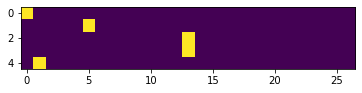

In [74]:
plt.imshow(xenc)

-------------
## 3.3. The "Neural Net": One Linear Layer of Neurons Implemented with Matrix Multiplication<a id="303"></a>
-------------------------------------------------------

In this section, we’ll train a neural network single layer. We define a simple model consisting of a single linear layer with 27 neurons, which takes an input vector `xenc` and matrix multiplies it on a weight matrix `W`. As output, the model gives us the firing rate of these 27 neurons to activate for each input.
This single linear layer NN is shown below:
```
                                                                       
    +------|------+             +------|------+               +------|------+    
    |  Input      |             | Hidden      |               | Output      |    
    |             |   --------> | Layer 1     |   -------->   |             |    
    |  27 inputs  |             | 27 neurons  |               | 27 outputs  |    
    +------|------+             +------|------+               +------|------+    
           |                           |                             |          
           |                           |                             |          
           X                          W.X                            y
                          (no bias, no non-linearity)
```  


`W` denotes weights of the neuron. We should initialize the weights. `torch.randn()` returns a tensor filled with random numbers from a normal distribution with mean of 0 and variance of 1 (also called the standard normal distribution). The figure below provides a diagram of the standard normal distribution.


<a id="a2"></a>
<img src="_imgs/standard_normal_dist.png" width="500" />

**<p style='text-align: center;'>
    Fig. 2: Standard Normal Distribution. ([Source](https://www.scribbr.com/statistics/normal-distribution/))</p>**

In [75]:
W = torch.randn((27, 1))
xenc @ W, (xenc @ W).shape # x.W + b (b=0) -->(5, 27) @ (27, 1) = (5, 1)

(tensor([[-1.0625],
         [-0.3362],
         [-0.1576],
         [-0.1576],
         [ 0.2913]]),
 torch.Size([5, 1]))


If we have a list of 5 inputs that we're feeding in, `xenc` would have dimensions of [5, 27]. We then matrix multiply `xenc` with `W`, which has dimensions of [27, 27], resulting in an output with dimensions of [10, 27]. These dimensions indicate how much each neuron was activated for each input. The `W` matrix has dimensions of [27, 27] due to our 27 input characters.

Whatt does the elements in `xenc @ W` tell us? For every one of the 27 neurons that we created, what is the firing rate of those neurons on every one of those 5 input examples?

In [76]:
W = torch.randn((27, 27))
xenc @ W, (xenc @ W).shape # x.W + b (b=0) -->(5, 27) @ (27, 27) --> (5, 27)

(tensor([[ 0.3511, -1.3343,  0.2300,  0.1161, -1.2495, -0.4252,  0.2622, -0.5628,
           1.6924,  0.0887, -1.3269,  0.4181, -0.7281,  1.0501, -1.4340, -1.0239,
           1.3424,  0.7052,  0.2834,  0.6834, -1.0444, -0.0467,  0.7428,  1.0718,
           1.6925, -1.7808, -0.5730],
         [-0.3898, -0.4574,  0.0630,  1.9943,  0.8991, -2.6819, -0.2330, -0.0900,
          -0.0619,  0.0641, -2.4325, -0.3533,  0.8803,  1.1718,  1.5721, -1.3941,
           2.8818, -0.3015,  0.0939,  0.9976,  0.7127,  0.1656,  0.7617, -0.0066,
           0.3755,  0.5801, -0.3290],
         [-0.2170, -0.5862, -0.6333, -1.3794,  1.3505,  0.0921,  0.0075,  0.5688,
          -0.1266,  2.1291, -0.2089, -0.6657,  0.4322,  0.5932, -1.2371,  0.5706,
           1.3471,  0.5504, -0.0464,  0.5128,  1.4832, -0.4115, -0.8705, -0.7297,
           0.7830, -0.8412,  1.2740],
         [-0.2170, -0.5862, -0.6333, -1.3794,  1.3505,  0.0921,  0.0075,  0.5688,
          -0.1266,  2.1291, -0.2089, -0.6657,  0.4322,  0.5932, -1

In [77]:
# the firing rate of the 13th neuron looking at the 3rd input
# this is achieved by the dot product between the 3rd input & the 13th column of W matrix

(xenc @ W)[3, 13] 

tensor(0.5932)

In [78]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [79]:
W[:, 13]

tensor([ 1.0501, -0.8092, -0.1201, -1.2197, -1.8305,  1.1718,  0.0450, -0.8061,
         1.9898,  1.4291,  0.9751,  2.3748, -0.5873,  0.5932, -1.4009,  0.9946,
        -0.3201,  0.2111,  0.5265, -1.0548,  0.2312, -0.0169,  0.6413,  0.1713,
        -0.7152,  0.7133,  0.7764])

In [80]:
(xenc[3] * W[:, 13]).sum() # W.x + b (b=0) --> W.x

tensor(0.5932)


We feed our 27 dimensional inputs into a single layer of a neural network (NN) that has 27 neurons. These neurons perform `W.X`. They don't have a bias (`b=0`) and a non-linearity (like `tanh`).<br><br>
$$
\sum_{i=1}^{n} w_i.x_i 
$$<br>
We're going to leave them to be a linear layer. In addition, we're not going to have any other layers. In essence, this is the dumbest, smallest, simplest neural net which is just a single linear layer. 

-------------
## 3.4. Softmax: Transform NN Outputs to Probabilities <a id="304"></a>
--------

In this section, we have to figure out what we want the 27 outputs of the neural network to be. We need to come up with precise semantics for exactly how we're going to interpret these 27 numbers from each neuron in the hidden layer. The outputs cannot be counts because they are `+ve` and **integers**. Instead, we can interpret these 27 numbers as **log counts (logits)**. To get linear counts, we need to exponentiate the log counts. This ensures that each output is now `+ve`. Probabilities can be found using the same procedure as before. They show just how likely each of the characters is to come next according to the model. As we adjust the `W` weights, we will get different probabilities for any character you enter. Basically we perform these steps:
1. Calculate the counts  
    1. Calculate the logits (log counts): `xenc @ W` (outputs: `+ve` & `-ve` numbers)
    2. Exponentiate the logits to ensure `+ve` outputs: `logits.exp()`. We call these `counts` now.
        - `x >= 0`: `exp(x) >= 1` 
        - `x < 0`: `0 < exp(x) < 1`
2.  Calculate probabilities: `counts / counts.sum(1, keepdims = True)`
3.  Calculate loss
<br><br>
<a id="a3"></a>
<img src="_imgs/exp_x.png" width="500" />

**<p style='text-align: center;'>
    Fig. 3: Graph of Exp(x) from x=-1 to x=1. ([Source](https://www.wolframalpha.com/input?i=exp%28x%29+from+-1+to+1))</p>**<br><br>


<u>Note:</u> Steps **1B and 2** combined together forms the **softmax activation**.

The [softmax function](https://en.wikipedia.org/wiki/Softmax_function) is a <u>normalized exponential function</u> that converts a vector of `K` real numbers into a probability distribution of `K` possible outcomes. It is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution over predicted output classes.<br><br>

<a id="c2"></a>
<img src="_imgs/softmax.png" width="500" />

**<p style='text-align: center;'>
    Eq 2: Softmax Activation Function. ([Source](https://towardsdatascience.com/softmax-activation-function-explained-a7e1bc3ad60))</p>**


In [81]:
logits = xenc @ W                               # log-count
counts = logits.exp()                           # equivalent to N
probs = counts / counts.sum(1, keepdims=True)   # probabilities for next character
probs

tensor([[0.0348, 0.0065, 0.0309, 0.0275, 0.0070, 0.0160, 0.0319, 0.0140, 0.1332,
         0.0268, 0.0065, 0.0373, 0.0118, 0.0701, 0.0058, 0.0088, 0.0939, 0.0496,
         0.0326, 0.0486, 0.0086, 0.0234, 0.0515, 0.0716, 0.1332, 0.0041, 0.0138],
        [0.0113, 0.0105, 0.0177, 0.1221, 0.0408, 0.0011, 0.0132, 0.0152, 0.0156,
         0.0177, 0.0015, 0.0117, 0.0401, 0.0536, 0.0801, 0.0041, 0.2966, 0.0123,
         0.0183, 0.0451, 0.0339, 0.0196, 0.0356, 0.0165, 0.0242, 0.0297, 0.0120],
        [0.0174, 0.0120, 0.0115, 0.0054, 0.0834, 0.0237, 0.0218, 0.0382, 0.0190,
         0.1817, 0.0175, 0.0111, 0.0333, 0.0391, 0.0063, 0.0382, 0.0831, 0.0375,
         0.0206, 0.0361, 0.0953, 0.0143, 0.0091, 0.0104, 0.0473, 0.0093, 0.0773],
        [0.0174, 0.0120, 0.0115, 0.0054, 0.0834, 0.0237, 0.0218, 0.0382, 0.0190,
         0.1817, 0.0175, 0.0111, 0.0333, 0.0391, 0.0063, 0.0382, 0.0831, 0.0375,
         0.0206, 0.0361, 0.0953, 0.0143, 0.0091, 0.0104, 0.0473, 0.0093, 0.0773],
        [0.0056, 0.0092,

In [82]:
probs.shape

torch.Size([5, 27])

In [83]:
probs[0].sum()

tensor(1.0000)

In [84]:
probs[0]

tensor([0.0348, 0.0065, 0.0309, 0.0275, 0.0070, 0.0160, 0.0319, 0.0140, 0.1332,
        0.0268, 0.0065, 0.0373, 0.0118, 0.0701, 0.0058, 0.0088, 0.0939, 0.0496,
        0.0326, 0.0486, 0.0086, 0.0234, 0.0515, 0.0716, 0.1332, 0.0041, 0.0138])

In [85]:
probs[0].shape

torch.Size([27])

-------------
## 3.5. Summary: Preview to Next Steps (Reference to Micrograd) <a id="305"></a>
--------

All of the functions we have used in the previous section in the forward pass (`logits`, `counts`, `probs`) are <u>differentiable operations</u>, so we will be able to calculate the gradients of weights based on them and <u>backpropagate through the entire neural network</u>. 

Let's put together all the steps from inputs into the single layer neural network to outputs. Our input is the first word **"emma"**

In [86]:
xs # inputs (['.', e, m, m, a]) 1st character as input

tensor([ 0,  5, 13, 13,  1])

In [87]:
ys # labels ([e, m, m, a, '.']) 2nd character as target value in brigram

tensor([ 5, 13, 13,  1,  0])

In [88]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

In [89]:
xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
logits = xenc @ W                             # predict log-counts
counts = logits.exp()                         # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [90]:
probs.shape

torch.Size([5, 27])

In [91]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------\n')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('\n=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------

bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------

bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 

<br><br>
This loss is made up of only differentiable operations. We can minimize the loss by tuning `W` by computing the gradients of the loss wrt to `W` matrix. Then we can tune `W` to minimize the loss and find a good setting of `W` using **gradient-based optimization**.

In essence we want to optimize the weight matrix `W` so that the output probabilities are quite good. The optimal parameters should minimize the loss function i.e. maximize the likelihood of the data with respect to the model parameters. This can be achieved by performing several operations at each iteration: 
1. a forward pass 
2. calculating the loss function 
3. a backward pass 
4. updating the parameters with the methods of gradient descent using information from the backpropagation algorithm.

This iterative process is called **gradient descent optimization** and is quite similar to how we trained the neural net in [micrograd](../001_micrograd/micrograd_from_scratch2.ipynb). The only difference we have is that instead of using **mean squared error** as the loss function, we’re using the **negative log-likelihood** because this is a <u>classification problem and not a regression problem.</u>

-------------
## 3.6. Vectorized Loss<a id="306"></a>
--------

Now we have a simple neural network and a loss function. We need to optimize our neural network by employing back-propagation to update the model parameters (weights) iteratively. For our loss function, we will use a vectorized negative log-likelihood.

In [92]:
probs.shape

torch.Size([5, 27])

In [93]:
probs[0, 5], probs[1, 13], probs[2, 13], probs[3, 1], probs[4, 0]

(tensor(0.0123),
 tensor(0.0181),
 tensor(0.0267),
 tensor(0.0737),
 tensor(0.0150))

In [94]:
torch.arange(5)

tensor([0, 1, 2, 3, 4])

In [95]:
loss = -probs[torch.arange(5), ys].log().mean()
loss

tensor(3.7693)

`torch.arange()` indexes a tensor with the number of entries we pass into it, with all the values added in an increasing order. For example, if I pass `torch.arange(5)` it will return a `tensor([0, 1, 2, 3, 4])`, so in this case we pass in all the inputs we have and use it to extract the predicted probabilities for the labels in ys tensor. And then we calculate the negative log (`-probs[ix_input, target_value].log()`) and then normalize it using the `mean()`.

-------------
## 3.7. `PyTorch`: Backward Pass & Parameter Update<a id="307"></a>
--------

Let's summarize all the steps leading to the forward pass (including the forward pass) and add the vectorized loss.

In [96]:
xs # inputs (['.', e, m, m, a]) 1st character as input

tensor([ 0,  5, 13, 13,  1])

In [97]:
ys # labels ([e, m, m, a, '.']) 2nd character as target value in brigram

tensor([ 5, 13, 13,  1,  0])

In [98]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [99]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
logits = xenc @ W                             # predict log-counts
counts = logits.exp()                         # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [100]:
print((loss.item()))

3.7693049907684326


In [101]:
# backward pass
W.grad = None     # set gradient to zero
loss.backward()

In [102]:
# update
W.data += -0.1 * W.grad

-------------
## 3.8. Putting Everything Together<a id="308"></a>
--------

Let's put all the steps together for the entire dataset (all the bigrams): 
* dataset creation, 
* network initialization & 
* gradient descent optimization (forward pass, backward pass, parameter update)

In [103]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [104]:
# gradient descent
for k in range(1):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    logits = xenc @ W                             # predict log-counts
    counts = logits.exp()                         # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() 
    print(k, loss.item())

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

0 3.758953332901001


In [105]:
def train_NN(n_iter=100, lr=50):
    losses, steps = [], []
    # gradient descent
    for k in range(n_iter):
        steps.append(k+1)
        
        # forward pass
        xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
        logits = xenc @ W                             # predict log-counts
        counts = logits.exp()                         # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
        loss = -probs[torch.arange(num), ys].log().mean() 
        #print(k, loss.item())
        losses.append(loss.item())

        # backward pass
        W.grad = None # set to zero the gradient
        loss.backward()

        # update
        W.data += -lr * W.grad
    return [steps, losses]

In [106]:
_train_loss = train_NN()

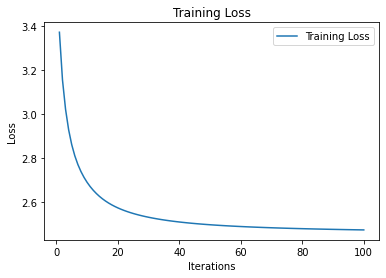

In [107]:
# Retrieve each dictionary's values
train_values = _train_loss[1]
 
# Generate a sequence of integers to represent the iteration numbers
n_iter = _train_loss[0]
 
# Plot and label the training and validation loss values
plt.plot(n_iter, train_values, label='Training Loss')
 
# Add in a title and axes labels
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(np.arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

The **gradient-descent optimized neural network loss** is roughly <u>the same</u> as the loss we calculated **using the relative counts**! Fundamentally, we do not give the neural network any additional information so this makes sense. Thus, the network must approximate the previous probability matrix.
However, the gradient-based approach is significantly more flexible. We can complexify the neural network to represent more and more complex structures.

The outputs of the neural network will always be logits. When we further complexify the network, **the only thing that will change is how we calculate the forward pass**. We can scale a neural network very easily.

-------------
## 3.9. Notes: Breakdown of One-Hot Encoding<a id="309"></a>
--------

One-hot encoded vectors `xenc` choose a row from the weights `W` matrix tensor, which is analogous to what we did in the simple probabilistic bigram model. 


For example, let's say we have a one-hot encoded vector that has a `1` at the `5th` dimension, when we perform matrix multiplication of `xenc` with `W`, we are essentially plucking out the `5th` row of `W` so logits will become the `5th` row of `W`. This row would tell us which character is most likely to come next because we calculate probabilities of bigrams.

-------------
## 3.10. Notes: Model Smoothing/Regularization Loss<a id="310"></a>
--------

In the probabilistic model, we used **model smoothing**. The more we smoothen our model, the more uniform the distribution of the probabilities becomes. The gradient-based approach has an equivalent to smoothing. Making `W`’s initial values to be near zero is equivalent to smoothing. This is called **regularization**. We redefine our loss with a regularization term.
* `loss_reg = 0.01*(W**2).mean()`

Let's dive deeper, previously we introduced a smoothing trick for the regularization of the statistical approach. It turns out that the gradient-based approach has the equivalent of smoothing. Consider the weight matrix `W` which we initialized randomly. We can think of initializing all weights `W` to be `0`. In this case, all the logits become zeros and their exponentiation gives all ones. Thus, the probability turns out to be <u>exactly uniform.</u> Therefore trying to incentivize/induce the **w’s to be close to zero** is basically the same as smoothing. This is called **regularization**. One can augment the loss function to have a small component that we call **regularization loss**. This new component tries to make all W’s zero and thus smoothen the probability matrix.

In [108]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [109]:
(W**2).mean()

tensor(0.9665, grad_fn=<MeanBackward0>)

In [110]:
# gradient descent
for k in range(1):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    logits = xenc @ W                             # predict log-counts
    counts = logits.exp()                         # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # added regularization term
    print(loss.item())

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

3.768618583679199


-------------
## 3.11. Sampling from Neural Net<a id="311"></a>
--------

For **gradient-based sampling**, we’ll use trained weights `W` matrix as our manually created `N` matrix. We’ll do

1.  Pluck the weight row corresponding to _'ix'_. This is our count.
2.  Exponentiate it to keep the ‘count’ positive.
3.  Get the probability distribution. (Remember **2**&**3** form **softmax** operation)
4.  Random sampling based upon the probability distribution

### The Manual Counting Approach

In [111]:
N = torch.zeros((27, 27), dtype=torch.int32)
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1
    

In [112]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

In [113]:
P.shape

torch.Size([27, 27])

In [114]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix] #P.shape = [27, 27]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


In [115]:
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')


print(f'\nlog_likelihood = {log_likelihood:.4f}')
nll = -log_likelihood
print(f'negative log_likelihood = {nll:.4f}')
avg_nll = nll/n
print(f'average negative log_likelihood = {avg_nll:.4f}')


log_likelihood = -559951.5625
negative log_likelihood = 559951.5625
average negative log_likelihood = 2.4544


### The gradient-based NN approach

In [116]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [117]:
# gradient descent
for k in range(25):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
    logits = xenc @ W                             # predict log-counts
    counts = logits.exp()                         # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # added regularization term
    print(loss.item())

    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

3.768618583679199
3.3788065910339355
3.161090135574341
3.0271854400634766
2.934483766555786
2.867231607437134
2.8166542053222656
2.777146339416504
2.745253801345825
2.7188305854797363
2.696505308151245
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886807441711426
2.5822560787200928
2.576429843902588
2.5711236000061035
2.5662729740142822
2.5618226528167725


In [118]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
    out = []
    ix = 0
    while True:

        # ----------
        # BEFORE:
#         p = P[ix] #P.shape = [27, 27]
        # ----------
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # ----------

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

moq.
axxaninaynnnyles.
kondmaisah.
anchunizarie.
odaren.


-----------
<br><br>
# 4. Conclusion<a id="4"></a>
-----------------

We introduced the bigram character-level language model. We trained, sampled from and evaluated the model using the negative log-likelihood loss. We trained the model in 2 different ways:
* we counted up frequency of bigrams and normalized the frequency
* we used negative log-likelihood loss as a guide to optimize the `counts` array so as to minimize the loss in a gradient-based framework.

Both approaches yielded the same result but the gradient-based framework is much more flexible. Our neural network is super simple, we're taking a single previous character and we're passing it through a single linear layer to calculate the logits. In the next lecture, this will complexify as we're going to take significantly more input characters and feed them into a neural net but this neural net would still output the same thing, basically logits. These logits will still be normalized in the same exact way and everything after (`counts`, `probs` & `loss`) stays identical as the gradient-based approach utilized in this notebook. However, the neural net `logits` will now complexify all the way to **transformers**.

-----
<br><br><a id="e1"></a>
# Exercises
----
1. Train a **trigram** language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a **bigram** model?
2. Split up the dataset randomly into <u>80% train set, 10% dev set, 10% test set</u>. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
3. Use the <u>dev set to tune the strength of smoothing (or regularization)</u> for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?
4. We saw that our 1-hot vectors merely select a row of `W`, so producing these vectors explicitly feels wasteful. Can you delete our use of `F.one_hot` in favor of simply indexing into rows of `W`?
5. Look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead?
6. Meta-exercise! Think of a fun/interesting exercise and complete it.

-----
<br><br><a id="r1"></a>
# References
----
1. "<u>The spelled-out intro to language modeling: building makemore</u>" [youtube video](https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3), Sept 2022.
2. Andrej Karpathy **Makemore** [github repo](https://github.com/karpathy/makemore).
3. Andrej Karpathy  **Neural Networks: Zero to Hero** [github repo](https://github.com/karpathy/nn-zero-to-hero/tree/master) ([notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part1_bigrams.ipynb) to follow video tutorial with).
4. Article: "<u>Language Modeling with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [1](https://medium.com/thedeephub/language-modeling-with-andrej-karpathy-part-1-4c55eb0db858), [2](https://medium.com/thedeephub/language-modeling-with-andrej-karpathy-part-2-8ef77b4981dc), [3](https://medium.com/thedeephub/language-modeling-with-andrej-karpathy-part-3-6810a3d15941), March 2024.
5. Article: "<u>Implementing a Character-Level Bigram Language Model Using Counts
</u>" - Tahir Rauf, Pt [1A](https://ai.plainenglish.io/implement-character-level-bigram-language-model-part-1-d1ffcafff551), [1B](https://medium.com/@tahir.rauf/character-level-bigram-language-model-using-neural-networks-part2-259836a11b15), Nov 2023.
6. "<u>Deep Dive into AI: Building a Bigram Language Model and Practicing Patience!</u>" - Ada Choudhry, [article](https://medium.com/@adachoudhry26/deep-dive-into-ai-building-a-bigram-language-model-and-practicing-patience-9341838063f7), Jan 2024.
7. "<u>Notes on Andrej Karpathy’s makemore videos. Part 1.</u>" - Maxime Markov, [article](https://medium.com/@maxmarkovvision/notes-on-andrej-karpathys-makemore-videos-part-1-ae78de651b26), Oct 2022.
8. "<u>Normal Distribution | Examples, Formulas, & Uses</u>" - Pritha Bhandari, [article](https://www.scribbr.com/statistics/normal-distribution/), June 2023.
9. Wikipedia: [Autoregressive Model](https://en.wikipedia.org/wiki/Autoregressive_model),
[Likelihood](https://en.wikipedia.org/wiki/Likelihood_function), 
[MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), 
[Negative Log Predictive Density](https://en.wikipedia.org/wiki/Negative_log_predictive_density),
[Softmax](https://en.wikipedia.org/wiki/Softmax_function)
10. PyTorch Resources: [Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html), [Multinomial Distribution](https://pytorch.org/docs/stable/generated/torch.multinomial.html),
[One-Hot Encoding](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html), [`.tensor` vs `.Tensor`](https://discuss.pytorch.org/t/difference-between-torch-tensor-and-torch-tensor/30786/2)
11. Wolfram Alpha: [log(x)](https://www.wolframalpha.com/input?i=log%28x%29+from+0+to+1),
[exp(x)](https://www.wolframalpha.com/input?i=exp%28x%29+from+-1+to+1)
12. Stack Overflow: [`torch.tensor` vs `torch.Tensor`](https://stackoverflow.com/questions/51911749/what-is-the-difference-between-torch-tensor-and-torch-tensor)

------